In [23]:
# Load Libraries and Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# Load datasets
credit_df = pd.read_csv('../data/raw/creditcard.csv')
fraud_df = pd.read_csv('../data/raw/Fraud_data.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

In [32]:
# Handle Missing Values
# Check missing values
print("Credit Card Data Missing:\n", credit_df.isnull().sum())
print("\nFraud Data Missing:\n", fraud_df.isnull().sum())
print("\nIP Address Data Missing:\n", ip_df.isnull().sum())

# Drop rows with any missing values for simplicity
credit_df.dropna(inplace=True)
fraud_df.dropna(inplace=True)
ip_df.dropna(inplace=True)


Credit Card Data Missing:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Fraud Data Missing:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

IP Address Data Missing:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


In [35]:
# Data Cleaning
# Remove duplicates
credit_df.drop_duplicates(inplace=True)
fraud_df.drop_duplicates(inplace=True)

# Convert timestamps
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'], dayfirst=True)
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'], dayfirst=True)

# Convert IPs to integer
fraud_df['ip_address'] = fraud_df['ip_address'].astype('int64')


## Exploratory Data Analysis (EDA)

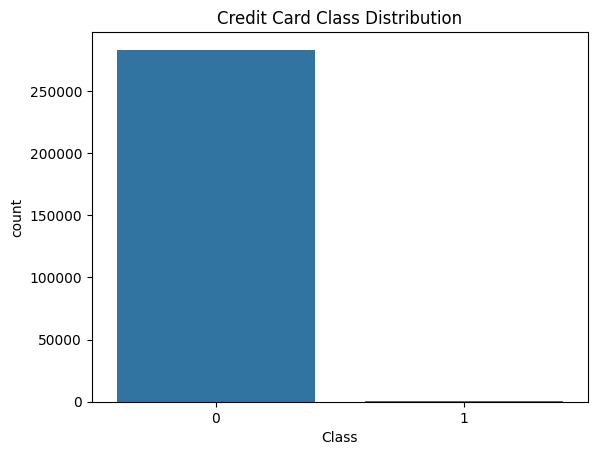

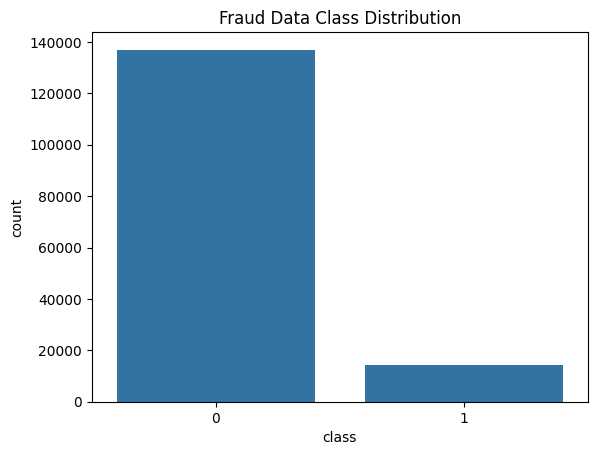

In [38]:
# A. Univariate Analysis (e.g., Class Distributions)
sns.countplot(data=credit_df, x='Class')
plt.title("Credit Card Class Distribution")
plt.show()

sns.countplot(data=fraud_df, x='class')
plt.title("Fraud Data Class Distribution")
plt.show()


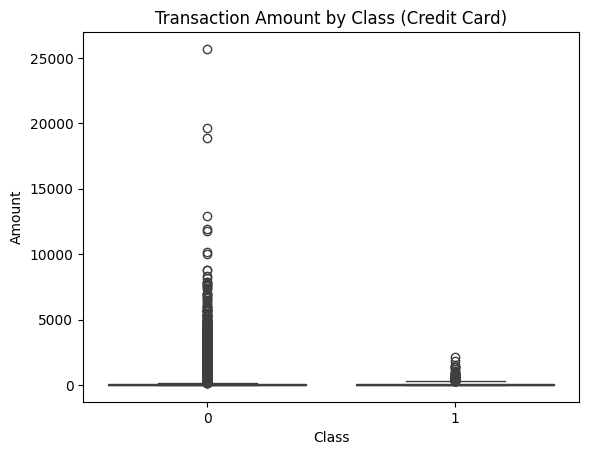

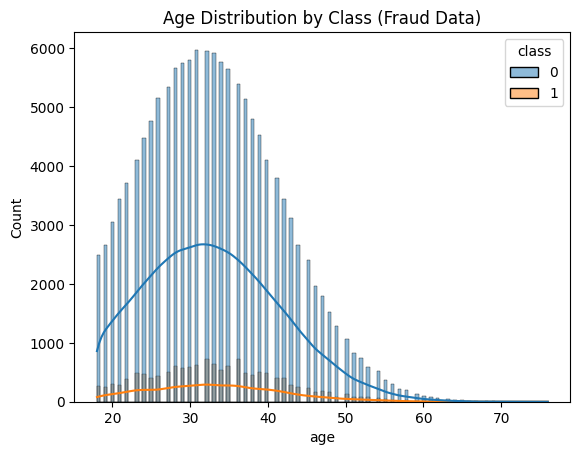

In [ ]:
# B. Bivariate Analysis

sns.boxplot(data=credit_df, x='Class', y='Amount')
plt.title("Transaction Amount by Class (Credit Card)")
plt.show()

sns.histplot(data=fraud_df, x='age', hue='class', kde=True)
plt.title("Age Distribution by Class (Fraud Data)")
plt.show()

In [40]:
# Merge Datasets for Geolocation Analysis
# Merge on IP Range
def map_ip_to_country(ip):
    row = ip_df[(ip_df['lower_bound_ip_address'] <= ip) & (ip_df['upper_bound_ip_address'] >= ip)]
    if not row.empty:
        return row.iloc[0]['country']
    return 'Unknown'

fraud_df['country'] = fraud_df['ip_address'].apply(map_ip_to_country)

In [41]:
# Feature Engineering
# Time-based features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# Velocity / Frequency
fraud_df['user_tx_count'] = fraud_df.groupby('user_id')['purchase_time'].transform('count')

In [42]:
# Handle Class Imbalance

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = fraud_df.drop(['class'], axis=1).select_dtypes(include=[np.number])
y = fraud_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [43]:
# Normalization and Encoding
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# One-Hot Encoding for Categorical features
X_cat = pd.get_dummies(fraud_df[['browser', 'source', 'sex']], drop_first=True)

In [44]:
# Save preprocessed dataset (with features + country)
fraud_df.to_csv('../data/processed/fraud_preprocessed.csv', index=False)

# Optional: Save processed training/testing data
np.save('../data/model_data/X_train_sm.npy', X_train_sm_scaled)
np.save('../data/model_data/y_train_sm.npy', y_train_sm)
np.save('../data/model_data/X_test.npy', X_test_scaled)
np.save('../data/model_data/y_test.npy', y_test)
